In [ ]:
!pip install langdetect datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
## Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import OneHotEncoder
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from langdetect import detect
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
nltk.download('stopwords')

## Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## Load listings data  (NYC)
nyc_train = pd.read_csv('nyc_train.csv')

## Load reviews data  (london)
london_train = pd.read_csv('london_train.csv')

## Concat the cities
train_set = pd.concat([nyc_train, london_train], axis=0)

## Display head
train_set.head(3)

,listing_id,listing_url,scrape_id,last_scraped,name,neighborhood_overview,host_id,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,...,calculated_host_listings_count,reviews_per_month,city,id,date,reviewer_id,reviewer_name,comments,polarity,polarity_class
0,3283409,https://www.airbnb.com/rooms/3283409,20240705150938,2024-07-05,Beautiful Brooklyn Brownstone,Bed-Stuy is a quiet neighborhood. Tree-lined s...,16593547,193,9,0,...,1,1.61,nyc,53603884,2015-11-10,44268857,Nancy,We had an amazing stay at Mary's and Josh's be...,0.9796,1.0
1,53031902,https://www.airbnb.com/rooms/53031902,20240705150938,2024-07-05,Urban Chic Riverview Corner Suite,"Vibrant neighborhood, with people having fun i...",206778021,37,1,0,...,12,1.13,nyc,775447743059830615,2022-12-05,427701377,Filipe,Thanks Vanessa!!,0.5399,1.0
2,611089534312850631,https://www.airbnb.com/rooms/611089534312850631,20240705150938,2024-07-05,Cozy and stylish ground floor guest suite,Morris park is the SAFEST neighborhood in the ...,19418202,115,25,0,...,1,4.41,nyc,763077599351696920,2022-11-18,38157718,Malvina,J'ai passé une excellent séjour chez Yulia et ...,0.5719,1.0


In [4]:
## Function to downsample the majority class and balance the data
def balance_data(df, target_column):
    """
    Downsample the majority class to balance the dataset.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    target_column (str): The name of the target column

    Returns:
    pd.DataFrame: Balanced DataFrame
    """
    ## Separate majority and minority classes
    majority_class = df[df[target_column] == df[target_column].value_counts().idxmax()]
    minority_class = df[df[target_column] != df[target_column].value_counts().idxmax()]

    ## Downsample majority class
    majority_class_downsampled = resample(majority_class,
                                          replace=False,
                                          n_samples=len(minority_class),
                                          random_state=123)

    ## Combine minority class with downsampled majority class
    balanced_df = pd.concat([minority_class, majority_class_downsampled])
    return balanced_df

In [ ]:
## TRAINING SET
## Balance the dataset
balanced_train_set = balance_data(train_set, 'polarity_class')
print(f"POLARITY CLASS DISTRIBUTION: {balanced_train_set['polarity_class'].value_counts()}")

In [5]:
## Function to preprocess Airbnb reviews
def preprocess_reviews(reviews):
    """
    Preprocess Airbnb reviews by removing HTML tags, stop words (excluding important negators),
    non-English reviews, and punctuations.

    Parameters:
    reviews (pd.Series): Series containing the reviews

    Returns:
    pd.Series: Cleaned reviews
    """
    stop_words = set(stopwords.words('english'))

    ## Remove negators from the stop words list to retain them in the text
    negators = {'not', 'no', 'nor', 'never', 'none', 'nothing', 'nowhere', 'neither', 'hardly', 'scarcely', 'barely', 'don’t', 'isn’t', 'wasn’t', 'shouldn’t', 'wouldn’t', 'couldn’t', 'won’t', 'can’t', 'don’t'}
    stop_words = stop_words - negators

    def clean_review(review):
        ## Remove HTML tags
        review = BeautifulSoup(review, "html.parser").get_text()

        ## Detect if the review is in English
        try:
            if detect(review) != 'en':
                return None
        except:
            return None

        ## Remove punctuations
        review = re.sub(f"[{string.punctuation}]", " ", review)

        ## Convert to lowercase and remove stop words
        review = ' '.join([word.lower() for word in review.split() if word.lower() not in stop_words])
        return review

    ## Apply the cleaning function to all reviews
    cleaned_reviews = reviews.apply(clean_review)

    return cleaned_reviews

In [ ]:
## TRAINING SET
## Preprocess reviews
balanced_train_set['cleaned_comments'] = preprocess_reviews(balanced_train_set['comments'])

## Drop rows where cleaned_comments is None (non-English reviews)
balanced_train_set = balanced_train_set.dropna(subset=['cleaned_comments'])
print(f"NEW DATA SIZE: {balanced_train_set.shape}")

In [ ]:
## Features
## Split the dataset into training and validation sets
train_df, val_df = train_test_split(balanced_train_set, test_size=0.2, random_state=42, stratify=balanced_train_set['polarity_class'].values)

## One-Hot encoding (polarity_class)
one_hot_encoder = OneHotEncoder(sparse=False)

train_df['polarity_class'] = list(one_hot_encoder.fit_transform(train_df[['polarity_class']]))
## Shuffle training DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

val_df['polarity_class'] = list(one_hot_encoder.fit_transform(val_df[['polarity_class']]))
## Shuffle training DataFrame
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Convert the split dataframes to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

## Print the number of samples in each dataset to verify the split
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

In [ ]:
## Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/rembert')

max_length = 256

## Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['cleaned_comments'], padding='max_length', truncation=True, max_length=max_length)

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

sentencepiece.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
## Tokenize the training set
train_dataset = train_dataset.map(tokenize_function, batched=True)
## Rename the target column to 'labels'
train_dataset = train_dataset.rename_column("polarity_class", "labels")
train_dataset = train_dataset.remove_columns(['cleaned_comments'])

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

## Tokenize the validation set
val_dataset = val_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.rename_column("polarity_class", "labels")
val_dataset = val_dataset.remove_columns(['cleaned_comments'])

val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
## Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('google/rembert', num_labels=balanced_train_set['polarity_class'].nunique())

## Freeze all layers except the classifier
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

## Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
)

## Define the compute_metrics function
def compute_metrics(p):
    pred_labels = p.predictions.argmax(-1)
    true_labels = p.label_ids.argmax(-1)
    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, output_dict=True)
    return {
        'accuracy': accuracy,
        'report': report
    }

## Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

## Train the model
trainer.train()

## Evaluate the model
results = trainer.evaluate()

## Print the results
print(f"Accuracy: {results['eval_accuracy']}")
print(f"Classification Report: {results['eval_report']}")

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

Some weights of RemBertForSequenceClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Report
1,0.445400,0.471356,0.774473,"{'0': {'precision': 0.918859649122807, 'recall': 0.07363796133567663, 'f1-score': 0.1363488447770908, 'support': 5690.0}, '1': {'precision': 0.7716204506065858, 'recall': 0.9979267062647091, 'f1-score': 0.8703024971900504, 'support': 17846.0}, 'accuracy': 0.7744731475186948, 'macro avg': {'precision': 0.8452400498646964, 'recall': 0.5357823338001929, 'f1-score': 0.5033256709835706, 'support': 23536.0}, 'weighted avg': {'precision': 0.8072166028651386, 'recall': 0.7744731475186948, 'f1-score': 0.6928638380198541, 'support': 23536.0}}"
2,0.448100,0.432862,0.803747,"{'0': {'precision': 0.9090909090909091, 'recall': 0.20913884007029876, 'f1-score': 0.3400485783683383, 'support': 5690.0}, '1': {'precision': 0.7975435281414496, 'recall': 0.9933318390675782, 'f1-score': 0.8847353579717016, 'support': 17846.0}, 'accuracy': 0.8037474507138002, 'macro avg': {'precision': 0.8533172186161793, 'recall': 0.6012353395689385, 'f1-score': 0.61239196817002, 'support': 23536.0}, 'weighted avg': {'precision': 0.8245109226690849, 'recall': 0.8037474507138002, 'f1-score': 0.7530533484567823, 'support': 23536.0}}"
3,0.404300,0.411361,0.824227,"{'0': {'precision': 0.8935631018753167, 'recall': 0.30984182776801406, 'f1-score': 0.4601331071381966, 'support': 5690.0}, '1': {'precision': 0.8178824838844316, 'recall': 0.9882326571780792, 'f1-score': 0.89502397929407, 'support': 17846.0}, 'accuracy': 0.8242267165193746, 'macro avg': {'precision': 0.8557227928798742, 'recall': 0.6490372424730466, 'f1-score': 0.6775785432161333, 'support': 23536.0}, 'weighted avg': {'precision': 0.8361788263541858, 'recall': 0.8242267165193746, 'f1-score': 0.7898859327879976, 'support': 23536.0}}"
4,0.393900,0.400177,0.833192,"{'0': {'precision': 0.8875219683655536, 'recall': 0.35500878734622143, 'f1-score': 0.5071554104946021, 'support': 5690.0}, '1': {'precision': 0.8273753527751646, 'recall': 0.9856550487504203, 'f1-score': 0.8996061985373089, 'support': 17846.0}, 'accuracy': 0.8331917063222298, 'macro avg': {'precision': 0.8574486605703591, 'recall': 0.6703319180483209, 'f1-score': 0.7033808045159555, 'support': 23536.0}, 'weighted avg': {'precision': 0.8419162366428274, 'recall': 0.8331917063222298, 'f1-score': 0.8047283525157674, 'support': 23536.0}}"
5,0.409300,0.396668,0.834551,"{'0': {'precision': 0.8867355727820844, 'recall': 0.3618629173989455, 'f1-score': 0.5139790314528206, 'support': 5690.0}, '1': {'precision': 0.8288394456490996, 'recall': 0.9852628039896896, 'f1-score': 0.9003072196620583, 'support': 17846.0}, 'accuracy': 0.834551325628824, 'macro avg': {'precision': 0.857787509215592, 'recall': 0.6735628606943176, 'f1-score': 0.7071431255574394, 'support': 23536.0}, 'weighted avg': {'precision': 0.8428362574857194, 'recall': 0.834551325628824, 'f1-score': 0.8069095568939344, 'support': 23536.0}}"


Trainer is attempting to log a value of "{'0': {'precision': 0.918859649122807, 'recall': 0.07363796133567663, 'f1-score': 0.1363488447770908, 'support': 5690.0}, '1': {'precision': 0.7716204506065858, 'recall': 0.9979267062647091, 'f1-score': 0.8703024971900504, 'support': 17846.0}, 'accuracy': 0.7744731475186948, 'macro avg': {'precision': 0.8452400498646964, 'recall': 0.5357823338001929, 'f1-score': 0.5033256709835706, 'support': 23536.0}, 'weighted avg': {'precision': 0.8072166028651386, 'recall': 0.7744731475186948, 'f1-score': 0.6928638380198541, 'support': 23536.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'0': {'precision': 0.9090909090909091, 'recall': 0.20913884007029876, 'f1-score': 0.3400485783683383, 'support': 5690.0}, '1': {'precision': 0.7975435281414496, 'recall': 0.9933318390675782, 'f1-score': 0.8847353579717016, 

Trainer is attempting to log a value of "{'0': {'precision': 0.8867355727820844, 'recall': 0.3618629173989455, 'f1-score': 0.5139790314528206, 'support': 5690.0}, '1': {'precision': 0.8288394456490996, 'recall': 0.9852628039896896, 'f1-score': 0.9003072196620583, 'support': 17846.0}, 'accuracy': 0.834551325628824, 'macro avg': {'precision': 0.857787509215592, 'recall': 0.6735628606943176, 'f1-score': 0.7071431255574394, 'support': 23536.0}, 'weighted avg': {'precision': 0.8428362574857194, 'recall': 0.834551325628824, 'f1-score': 0.8069095568939344, 'support': 23536.0}}" of type <class 'dict'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Accuracy: 0.834551325628824
Classification Report: {'0': {'precision': 0.8867355727820844, 'recall': 0.3618629173989455, 'f1-score': 0.5139790314528206, 'support': 5690.0}, '1': {'precision': 0.8288394456490996, 'recall': 0.9852628039896896, 'f1-score': 0.9003072196620583, 'support': 17846.0}, 'accuracy': 0.834551325628824, 'macro avg': {'precision': 0.857787509215592, 'recall': 0.6735628606943176, 'f1-score': 0.7071431255574394, 'support': 23536.0}, 'weighted avg': {'precision': 0.8428362574857194, 'recall': 0.834551325628824, 'f1-score': 0.8069095568939344, 'support': 23536.0}}


In [6]:
## Save the model
model_save_path = '/content/drive/MyDrive/Airbnb/Models'
#trainer.save_model(model_save_path)

In [8]:
## Load the test data
test_df = pd.read_csv("/content/drive/MyDrive/Airbnb/Dataset/preprocess_test.csv")#pd.concat([pd.read_csv('/content/drive/MyDrive/Airbnb/Dataset/london_test.csv'), pd.read_csv('/content/drive/MyDrive/Airbnb/Dataset/nyc_test.csv')], axis=0)

## Preprocess the test data5
#test_df['cleaned_comments'] = preprocess_reviews(test_df['comments'])

## One-Hot encoding (polarity_class)
one_hot_encoder = OneHotEncoder(sparse=False)

## Convert one-hot encoded lists back to class indices if needed
test_df['polarity_class'] = list(one_hot_encoder.fit_transform(test_df[['polarity_class']]))
#test_df.to_csv("/content/drive/MyDrive/Airbnb/Dataset/preprocess_test.csv", index=False)

## Convert the test dataframe to a Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)

In [9]:
## Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/rembert')

max_length = 256

## Tokenize the dataset
def tokenize_function(examples):
    cleaned_comments = [str(comment) for comment in examples['cleaned_comments']]
    return tokenizer(cleaned_comments, padding='max_length', truncation=True, max_length=max_length)

## Tokenize the training set
test_dataset = test_dataset.map(tokenize_function, batched=True)

## Rename the target column to 'labels'
test_dataset = test_dataset.rename_column("polarity_class", "labels")
test_dataset = test_dataset.remove_columns(['cleaned_comments'])

test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

sentencepiece.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Map:   0%|          | 0/497623 [00:00<?, ? examples/s]

In [10]:
## Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=1024,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
)

## Load the saved model
model = AutoModelForSequenceClassification.from_pretrained(model_save_path)

## Define the compute_metrics function
def compute_metrics(p):
    pred_labels = p.predictions.argmax(-1)
    true_labels = p.label_ids.argmax(-1)
    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, output_dict=True)
    return {
        'accuracy': accuracy,
        'report': report
    }

## Initialize the Trainer with the loaded model
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

# ## Evaluate the model on the test dataset
# test_results = trainer.evaluate(test_dataset)

# ## Print the results
# print(f"Test Accuracy: {test_results['eval_accuracy']}")
# print(f"Test Classification Report: {test_results['eval_report']}")

## Generate predictions for the test dataset
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids.argmax(-1)

In [13]:
predictions

PredictionOutput(predictions=array([[-1.0795977 ,  1.0698388 ],
       [-1.9789876 ,  1.9550242 ],
       [-1.6556386 ,  1.6751975 ],
       ...,
       [-1.3576977 ,  1.3262404 ],
       [-1.2425226 ,  1.2265315 ],
       [-0.97325677,  0.9627549 ]], dtype=float32), label_ids=array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32), metrics={'test_loss': 1.749699354171753, 'test_accuracy': 0.05404693914871298, 'test_report': {'0': {'precision': 0.695712954333644, 'recall': 0.012596817468486864, 'f1-score': 0.024745582921735676, 'support': 474088.0}, '1': {'precision': 0.04278390884980544, 'recall': 0.889016358614829, 'f1-score': 0.08163894384030404, 'support': 23535.0}, 'accuracy': 0.05404693914871298, 'macro avg': {'precision': 0.3692484315917247, 'recall': 0.4508065880416579, 'f1-score': 0.05319226338101986, 'support': 497623.0}, 'weighted avg': {'precision': 0.6648327798130488, 'recall': 0.05404693914871298, '

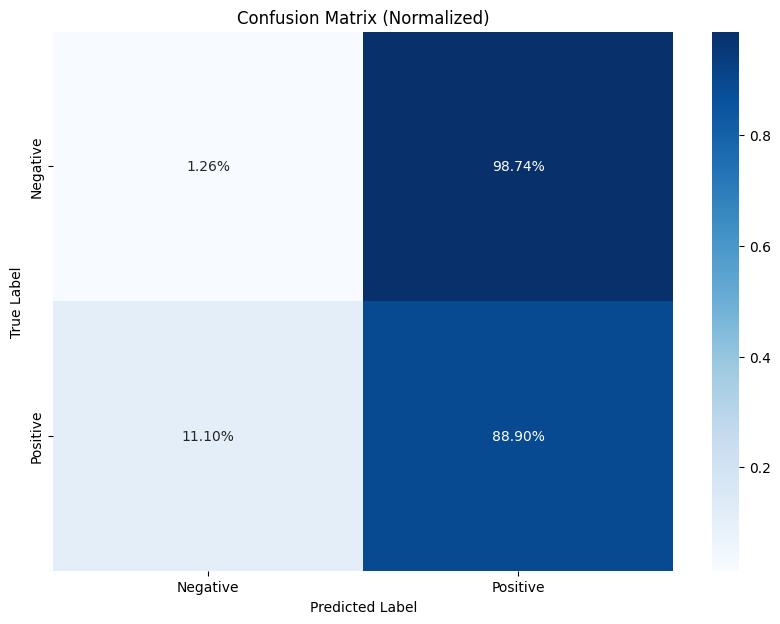

In [12]:
## Generate the confusion matrix and normalize it
cm = confusion_matrix(true_labels, pred_labels, normalize='true')

## Plot the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized)')
plt.show()